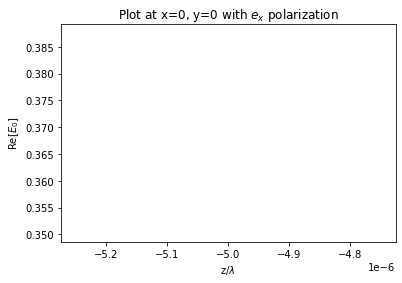

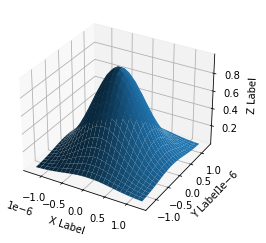

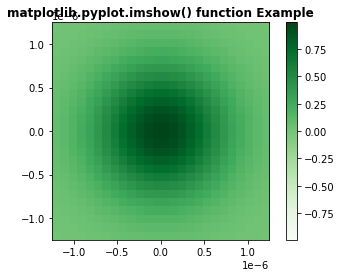

In [1]:
import numpy.matlib
import numpy as np
import cmath
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import gaussian_beam as beam

In [2]:
j=complex(0,1) # iota , sqrt of -1
n_side=26# no. of atoms along an edge of the array
n=n_side**2 # for a square atomi array
c_light=3*10**8 #m/s speed of light
lamda=500 * 10**-9# (in m) wavelength of light
w=2*np.pi*c_light/lamda
a=0.2*lamda# interatomic distance
L=(n_side-1)*a # length of the atomic array
k=2*np.pi/lamda # wavenumber of incidnet light
epsilon=8.85*10**-12# SI units, permitivitty of free space

m=9.1*10**-31# kg mass of electron
e=1.6*10**-19 # Coulomb electronic charge
r_atom=0.59 *10**-10# m H atom radius
#w_a=np.sqrt(2*e**2/(m*(r_atom**3)*(4*np.pi*epsilon)))

#assuming no non-radiative losses and w_a=w

w_a=w 
lamda_a=c_light/(w_a/(2*np.pi))

alpha=3/(4*np.pi**2)*epsilon*lamda_a**3*j # polarization of an atom


$\textbf{R}$ stores the positions of the atoms. $\textbf{R}$ has form $[(x_{1},y_{1},z_{1}),(x_{2},y_{2},z_{2}),...)]$\
where $(x_{i},y_{i},z_{i})$ are the positions of the $i^{th}$ atom\
The placement of the atoms starts from x=-L/2,y=L/2 such that the atom with index 1 is at (-L/2,L/2)\
consequent atoms are placed from x=$-L/2$,y=$L/2$ to x=$L/2$,y=$L/2$ with interatomic distance $a$\, then from y=$L/2$ to y=$-L/2$, filling one row at a time

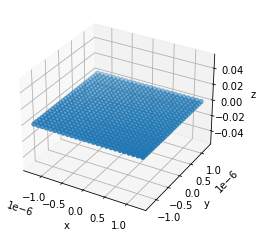

In [3]:

R=np.zeros(shape=(n,3)) 
for i in range(0,n):
    R[i]=((-L/2+a*(i%n_side)),(L/2-a*int((i/n_side))),0)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.view_init(3*10**-7,2*10**-7,'x')
ax.scatter3D(R[:,0],R[:,1],R[:,2],cmap="Greens")


In [4]:
def kron_delt(x,y):
    '''This is the kroncker delta function'''
    if (x==y):
        return 1
    else:
        return 0
    
    
def exp_i(a):
    '''converts the given phase into complex number and returns cartesian'''

    x=np.cos(a) + np.sin(a)*j
    return x
def Greens(m,l,k,r_1,r_2):
    '''Calculates the greens function G_{ml}(r_1,r_2)'''
    if ((r_1[0]==r_2[0])and(r_1[1]==r_2[1])and(r_1[2]==r_2[2])):    #skip the same atom
        return 0
    else:
        r_vect=r_1-r_2 
        r=np.sqrt(np.sum(np.square(r_vect)))
        c_1=(k*r)*j
        if m==l: # serves as kronecker delta
            t1=(1+ (c_1-1)/((k*r)**2))
        else:
            t1=0
        t2=(-1 + (3-3*c_1/(k*r)**2))*r_vect[m]*r_vect[l]/r**2
        t3=exp_i(k*r)/(4*np.pi*r)*(t1+t2)
        return t3
    

In [5]:

G=np.empty(shape=(n,3,n,3),dtype=np.complex_)

#print(G)
for r_1 in range(0,n):      
        for m in range(0,3):
              for r_2 in range(0,n):
                    for l in range(0,3):
                        G[r_1,m,r_2,l]=Greens(m,l,k,R[r_1],R[r_2])
                    


G stores the components of Green's function in the format $G_{ij}(r,r_{n})$ \
The rows are indexed as (n,i) ($n$ for indexing $r$), i is the component ( i= x,y,z) n is the index of the atom,\
$1^{st}$, $2^{nd}$,$3^{rd}$,$4^{th}$,... rows are (n,i)=(1,x),(1,y),(1,z),(2,x),... \
The columns are indexed as (n,j) ($n$ for indexing $r_{n}$) and j=x,y,z ( polarization of the delta source)\



In [6]:
G_M=G.reshape(3*n,3*n)
# now  is in 3n * 3n matrix  form  
I_M=np.identity(3*n,dtype=np.complex_)
INVERSE_M=np.linalg.inv(I_M-(4*(np.pi**2)*alpha/(epsilon*lamda**2)*G_M))
#import sys

#np.set_printoptions(threshold=sys.maxsize)
#print(G)

In [7]:
E_0_at_atoms=beam.re_E_n +j*beam.im_E_n # E_0 is at atoms
E_0_V=E_0_at_atoms.reshape(3*n,1)

In [8]:
E_at_atoms_V=np.matmul(INVERSE_M,E_0_V)

In [9]:
E_at_atoms=E_at_atoms_V.reshape(n,3)

In [10]:
def E(x,y,z,E_at_atoms):#e-x =1,0,0
    E_space=np.zeros(shape=(3,),dtype=np.complex_)
    t=4*(np.pi**2)*alpha/(epsilon*lamda**2)
    E_0_at_r=beam.gaussian_beam(x,y,z,w,lamda,np.array([1,0,0]))
    for i in range(0,3):
        G=0
        for j_dash in range(0,3):
            for atoms_index in range(0,n):
                G+=Greens(i,j_dash,k,(x,y,z),R[atoms_index])*E_at_atoms[atoms_index,j_dash]
        E_space[i]=E_0_at_r[2][i]+t*G
        
        
    return E_space
    

In [11]:
perpendicular_direction=np.arange(-5*lamda,5*lamda,a/5)
E_perpendicular_to_array=np.zeros(shape=(perpendicular_direction.shape),dtype=np.complex_)
for i in range(0,len(perpendicular_direction),1):
    E_perpendicular_to_array[i]=E(0,0,perpendicular_direction[i],E_at_atoms)[0]


#x=30+4*10j
#abs(x)

Text(0, 0.5, 'E')

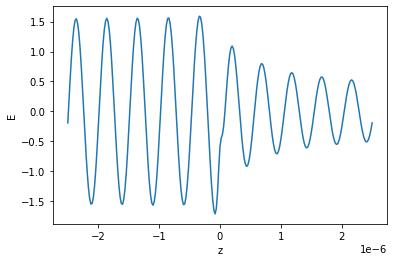

In [12]:
plt.plot(perpendicular_direction,E_perpendicular_to_array.real)    
plt.xlabel('z')
plt.ylabel('E')


In [13]:
E(0,0,perpendicular_direction[5],E_at_atoms)

array([ 1.39428163e+00+3.61587451e-01j, -4.75965933e-17+6.93245461e-17j,
        4.27338165e-16-2.84705592e-17j])